In [1]:
!pip install scikit-posthocs

     |████████████████████████████████| 43 kB 2.4 MB/s eta 0:00:011
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Created wheel for scikit-posthocs: filename=scikit_posthocs-0.6.7-py3-none-any.whl size=37886 sha256=f47337b46b19536fe0e853bbdecacb3a2247b10bb170807c91cac41044e9bde3
  Stored in directory: /home/jarvis4444/.cache/pip/wheels/9d/b3/0e/48fc4edf03f0cace0bb10215f6103591b62f143ace946c193c
Successfully built scikit-posthocs


In [5]:
#Importing Libraries
import os
import pandas as pd
import numpy as np
import utility as util
import math
import matplotlib.pyplot as plt
from factor_analyzer.factor_analyzer import FactorAnalyzer
from factor_analyzer.factor_analyzer import calculate_bartlett_sphericity
import scikit_posthocs as sp
from scipy.stats import ttest_ind_from_stats
from scipy.stats import mannwhitneyu
from scipy.optimize import curve_fit
import seaborn as sns
import plotly
import plotly.graph_objects as go    # for data visualisation
import plotly.figure_factory as ff
import plotly.express as px
from pycountry_convert import country_name_to_country_alpha3 # for choropleth maps

In [100]:
df=pd.read_csv('../../data/dtrap/countries.csv')

#df.iloc[:,np.r_[:,23:324]].columns.tolist()

colnames=df.columns.tolist()
cverange = [colnames.index(l) for l in colnames if l.startswith('CVE-')]


In [8]:
#from https://www.imd.org/wcc/world-competitiveness-center-rankings/world-digital-competitiveness-rankings-2020/
top_gdp=['United Kingdom','Austria','Hong Kong','United Arab Emirates','Norway','Singapore','Denmark','Sweden','Switzerland','Netherlands','South Korea','Finland','Taiwan','Taiwan','Canada','Australia','Germany','Estonia','Israel','Ireland','New Zealand','Iceland','France','Belgium','Japan','Saudi Arabia','Luxembourg','Qatar','Slovenia','Spain','Saudi Arabia','Czech Republic','Portugal','Cyprus','Italy']
bottom_gdp=['China','Malyasia','Lithuania','Poland','Kazakhstan','Latvia','Thailand','Chile','Russia','Turkey','Bulgaria','Greece','Hungary','India','Romania','Slovak Republic','Brazil','Croatia','Jordan','Mexico','Peru','Indonesia','Philippines','Ukraine','Argentina','South Africa','Colombia','Mongolia']

Enrich dataframe with cvss info

In [10]:
df_cvss=pd.read_csv('../../data/dtrap/exposure-count.csv')

def getbscorebyname(cve):  #return CVSSv3 base score by CVE ID
    return(df_cvss['cvss3_basescore'][df_cvss.vulnerability.str.contains(cve.strip())].values[0])

def getbscorebyname2(cve):  #return CVSSv2 base score by CVE ID
    return(df_cvss['cvss2_basescore'][df_cvss.vulnerability.str.contains(cve.strip())].values[0])


def ttestcountries(c1, c2):  #perform a t-test on two countries
    mean1, std1, nobs1 = country_bscore[country_bscore.country==c1][['avg','std','ncve']].values[0]
    mean2, std2, nobs2 = country_bscore[country_bscore.country==c2][['avg','std','ncve']].values[0]
    return(ttest_ind_from_stats(mean1, std1, nobs1, mean2, std2, nobs2, equal_var=False))


In [11]:
#create a dataframe with the CVSS score averages and standard deviation info
country_bscore=df.copy()

country_bscore['vulnper1k']=country_bscore['totalcount']/(country_bscore['population_2020']/1000)

cvelist=df.iloc[:,np.r_[:,min(cverange):max(cverange)+1]].columns.tolist() #this needs to become neat, parse all columns starting with "CVE-"

country_bscore['ncve']=country_bscore['avg']=0
country_bscore['ncve2']=country_bscore['avg2']=0  #cvss2


for i in cvelist:
    country_bscore['ncve']+=country_bscore[i]
    country_bscore['avg']+=country_bscore[i]*getbscorebyname(i)
    country_bscore['ncve2']+=country_bscore[i]                        #cvss2
    country_bscore['avg2']+=country_bscore[i]*getbscorebyname2(i)    #cvss2

country_bscore['exposure']=country_bscore['avg']
country_bscore['exposureperperson']=country_bscore['avg']/(country_bscore['population_2020'])
country_bscore['avg']/=country_bscore.ncve
country_bscore['avg2']/=country_bscore.ncve   #cvss2


country_bscore['std']=0    
country_bscore['std2']=0     #cvss2


for i in cvelist:
    country_bscore['std']+=country_bscore[i]*(country_bscore['avg']-getbscorebyname(i))**2
    country_bscore['std2']+=country_bscore[i]*(country_bscore['avg2']-getbscorebyname2(i))**2  #cvss2

country_bscore['std']/=country_bscore.ncve
country_bscore['std']=np.sqrt(country_bscore['std'])

country_bscore['std2']/=country_bscore.ncve                #cvss2
country_bscore['std2']=np.sqrt(country_bscore['std2'])     #cvss2


country_bscore[['country','totalcount','vulnper1k','ncve','avg','std','avg2','std2', 'exposure','exposureperperson']].describe()

,totalcount,vulnper1k,ncve,avg,std,avg2,std2,exposure,exposureperperson
count,2.470000e+02,2.410000e+02,2.470000e+02,247.000000,247.000000,247.000000,247.000000,2.470000e+02,241.000000
mean,8.443286e+05,2.741690e+04,8.444824e+05,7.522181,1.604216,5.565825,1.332070,6.322610e+06,211.572680
std,3.359074e+06,3.571325e+05,3.359581e+06,0.317437,0.131439,0.186953,0.130714,2.490640e+07,2794.319244
min,0.000000e+00,1.649823e-02,3.000000e+01,6.250636,0.466977,4.548996,0.440820,2.169000e+02,0.000127
25%,5.468000e+03,1.920504e+00,5.468000e+03,7.320675,1.585355,5.496677,1.267519,4.139985e+04,0.014752
50%,3.306100e+04,1.555102e+01,3.306100e+04,7.582448,1.632663,5.581419,1.362632,2.523687e+05,0.119867
75%,3.080950e+05,1.263333e+02,3.081225e+05,7.732167,1.670477,5.657164,1.415005,2.341560e+06,0.948995
max,3.466126e+07,5.515871e+06,3.466703e+07,9.174815,1.898584,6.848239,1.637865,2.543718e+08,43199.725125


In [12]:
exposureperperson_topgdp=country_bscore[country_bscore.country.isin(top_gdp)][['country','exposureperperson']].sort_values(by='exposureperperson', ascending=False)
exposureperperson_bottomgdp=country_bscore[country_bscore.country.isin(bottom_gdp)][['country','exposureperperson']].sort_values(by='exposureperperson', ascending=False)
exposureperperson_topgini=country_bscore[country_bscore.exposureperperson<10][country_bscore.country.isin(top20_gini.country)][['country','exposureperperson']].sort_values(by='exposureperperson', ascending=False)
exposureperperson_bottomgini=country_bscore[country_bscore.exposureperperson<10][country_bscore.country.isin(bottom20_gini.country)][['country','exposureperperson']].sort_values(by='exposureperperson', ascending=False)

print(np.exp(35.695))
#city_bscore.city_type.hist()

fig = go.Figure()
fig.add_histogram(x=exposureperperson_topgini.exposureperperson)
fig.add_histogram(x=exposureperperson_bottomgini.exposureperperson)

fig.update_layout(title='',
                  xaxis = dict(title='exposure per person'), # categoryorder='array' ,categoryarray=['LOW','MEDIUM','HIGH','CRITICAL']),
                  yaxis = dict(title='Count'))

#fig.update_traces(opacity=0.75)

NameError: name 'top20_gini' is not defined

In [15]:
print(exposureperperson_topgini.describe())
print(exposureperperson_bottomgini.describe())


NameError: name 'exposureperperson_topgini' is not defined

In [16]:
fig = go.Figure()


# Add traces
fig.add_trace(go.Scatter(x=country_bscore[(country_bscore.exposureperperson<5) & (country_bscore.gini_value>20)]['exposureperperson'], 
                         y=np.log(country_bscore[(country_bscore.exposureperperson<5) & (country_bscore.gini_value>20)]['gini_value']),
                    mode='markers',
                    name='markers'))

In [17]:
country_bscore[(country_bscore.exposureperperson<5) & (country_bscore.gini_value>0)]['exposureperperson'].corr(country_bscore[(country_bscore.exposureperperson<5) & (country_bscore.gini_value>0)]['gini_value'])

-0.08009056324000972

In [18]:
country_bscore[(country_bscore.exposureperperson<5) & 
               (country_bscore.factor_technology>0)]['exposureperperson'].corr(country_bscore[(country_bscore.exposureperperson<5) & 
                                                                                       (country_bscore.factor_technology>0)]['factor_technology'])

-0.319058111177202

In [22]:
gdp=pd.read_csv('../../data/dtrap//gdp.csv')
ccode=pd.read_csv('../../data/dtrap//country_iso.csv')
ccode.head(10)

def getincomebyccode(ccode2):
    try:
        ccode3=ccode[ccode['country_code']==ccode2]['ccode3'].values[0]
        return(gdp[gdp['Country Code']==ccode3]['IncomeGroup'].values[0][:-7])
    except :
        return(np.nan)
    

In [23]:
getincomebyccode('AL')

'Upper middle'

In [24]:
country_bscore['income_group']=country_bscore['country_code'].map(getincomebyccode)

country_bscore['gini_value']=np.where(country_bscore.gini_value>0, country_bscore.gini_value, np.nan)


In [28]:
x=country_bscore[(country_bscore.exposureperperson<5) & (country_bscore.gini_value>0)]['exposureperperson']
y=country_bscore[(country_bscore.exposureperperson<5) & (country_bscore.gini_value>0)]['gini_value']

#np.polyfit(np.log(x),y,1)  # y=A + B log x
#params, pcov =curve_fit(lambda t,a,b: a*np.exp(b*t), x, y, p0=[4,-0.1])
params, pcov =curve_fit(lambda t,a,b: a+b*np.log(t), x, y)
#fit1=params[0]*np.exp(params[1]*x)
fit2=params[0]+params[1]*np.log(x)
print(params,'\n',pcov,fit2)
country_bscore[[ 'country','income_group','population_2020',
        'overall_performance', 'factor_knowledge',
       'factor_technology', 'factor_future_readiness', 'subfact_know_talent',
       'subfact_know_training_education',
       'subfact_know_scientific_concentration',
       'subfact_tech_regulatory_framework', 'subfact_tech_capital',
       'subfact_tech_technological_framework', 'subfact_fr_adaptive_attitudes',
       'subfact_fr_business_agility', 'subfact_fr_it_integration',
       'gini_value', 'totalcount','avg','vulnper1k','exposureperperson']].to_csv('../../data/dtrap/exposure_g1.csv')

[35.73158129 -0.91793683] 
 [[1.18691661 0.24796213]
 [0.24796213 0.07781194]] 2      38.232775
3      41.041360
6      41.058516
9      38.133749
10     36.012541
         ...    
240    39.894389
241    39.212834
244    36.754058
245    40.789567
246    40.480285
Name: exposureperperson, Length: 148, dtype: float64


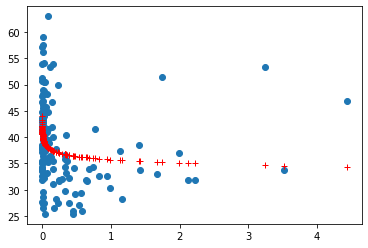

In [29]:
plt.plot(x, y, 'o', label="y-original")
plt.plot(x,fit2,'r+')

In [30]:
ttestcountries('Andorra','Yemen')

Ttest_indResult(statistic=3.3747513863256464, pvalue=0.0007399442863508931)

In [31]:
top_vuln_countries=country_bscore[['country','totalcount','ncve','avg','std']].sort_values(by='avg', ascending=False).head(30)

In [32]:
ttestcountries('Lebanon','Niue')

Ttest_indResult(statistic=5.864105182751156, pvalue=4.519355674642435e-09)

In [33]:
top_gdp_cve=country_bscore[['country','totalcount','ncve','avg','std']][country_bscore.country.isin(top_gdp)].sort_values(by='avg', ascending=False)

In [34]:
ttestcountries('Singapore','Switzerland')

Ttest_indResult(statistic=-128.5947808778528, pvalue=0.0)

In [35]:
top_gdp_cve.describe()

,totalcount,ncve,avg,std
count,3.300000e+01,3.300000e+01,33.000000,33.000000
mean,1.476177e+06,1.476219e+06,7.663650,1.654314
std,1.992775e+06,1.992856e+06,0.224594,0.052935
min,6.940000e+03,6.940000e+03,7.096534,1.525540
25%,1.407400e+05,1.407520e+05,7.586454,1.639208
50%,6.143100e+05,6.143100e+05,7.680451,1.658391
75%,2.439834e+06,2.439888e+06,7.797807,1.677193
max,8.102432e+06,8.103146e+06,8.046173,1.839198


In [36]:
top_vuln_countries.describe()

,totalcount,ncve,avg,std
count,3.000000e+01,3.000000e+01,30.000000,30.000000
mean,4.771415e+05,4.771638e+05,7.994191,1.583486
std,1.316038e+06,1.316137e+06,0.234829,0.126907
min,4.350000e+02,4.350000e+02,7.846275,1.243473
25%,1.781075e+04,1.781075e+04,7.904873,1.613820
50%,1.191955e+05,1.191955e+05,7.939898,1.634186
75%,2.834148e+05,2.834290e+05,8.004204,1.657188
max,6.774998e+06,6.775599e+06,9.174815,1.683552


In [37]:
mannwhitneyu(top_gdp_cve['avg'],top_vuln_countries['avg'])

MannwhitneyuResult(statistic=98.0, pvalue=2.4206238209381464e-08)

In [38]:

bottom_gdp_cve=country_bscore[['country','totalcount','ncve','avg','std']][country_bscore.country.isin(bottom_gdp)].sort_values(by='avg', ascending=False)

In [39]:
bottom_gdp_cve.describe()

,totalcount,ncve,avg,std
count,2.700000e+01,2.700000e+01,27.000000,27.000000
mean,2.578059e+06,2.578405e+06,7.688274,1.603278
std,6.673748e+06,6.674834e+06,0.234630,0.107972
min,1.388500e+04,1.388500e+04,7.176380,1.243473
25%,1.610520e+05,1.610610e+05,7.590544,1.593957
50%,4.153570e+05,4.153570e+05,7.649784,1.628174
75%,1.875798e+06,1.876071e+06,7.852742,1.667403
max,3.466126e+07,3.466703e+07,8.067863,1.736824


In [40]:
mannwhitneyu(bottom_gdp_cve['avg'],top_gdp_cve['avg'])

MannwhitneyuResult(statistic=425.0, pvalue=0.383165257951529)

In [41]:
mannwhitneyu(top_gdp_cve['avg'],top_vuln_countries['avg'])

MannwhitneyuResult(statistic=98.0, pvalue=2.4206238209381464e-08)

In [42]:
mannwhitneyu(bottom_gdp_cve['avg'],top_vuln_countries['avg'])

MannwhitneyuResult(statistic=132.5, pvalue=6.880915731583277e-06)

In [43]:
set(bottom_gdp) & set(top_vuln_countries.country)

{'Argentina',
 'Bulgaria',
 'Greece',
 'Latvia',
 'Lithuania',
 'Poland',
 'Slovak Republic'}

In [44]:
set(top_gdp) & set(top_vuln_countries.country)

{'Austria', 'Czech Republic', 'Denmark', 'New Zealand', 'Norway', 'Sweden'}

In [45]:
set(top_gdp) & set(bottom_gdp) #just checking

set()

In [46]:
top_vuln_countries

,country,totalcount,ncve,avg,std
116,Kuwait,21068,21068.0,9.174815,1.338345
240,Venezuela,37339,37339.0,8.169533,1.628903
119,Latvia,108938,108938.0,8.067863,1.664959
91,Guinea,1071,1071.0,8.061064,1.631290
58,Denmark,144578,144579.0,8.046173,1.666634
196,Slovak Republic,117363,117363.0,8.029063,1.653237
174,Republic of Moldova,222126,222127.0,8.027228,1.634347
125,Lithuania,382533,382539.0,8.008227,1.591884
242,Wallis and Futuna,2136,2136.0,7.992135,1.344734
21,Belize,161317,161320.0,7.986741,1.305961


In [47]:
#top20_gini=country_bscore[['country','totalcount','ncve','avg','std','gini_value']][country_bscore.country.isin(bottom_gdp)].sort_values(by='gini_value', ascending=False).head(30)
#bottom20_gini=country_bscore[['country','totalcount','ncve','avg','std','gini_value']][(country_bscore.country.isin(bottom_gdp)) & (country_bscore.gini_value>0)].sort_values(by='gini_value', ascending=True).head(30)

giniset=set(top_gdp)|set(bottom_gdp)


top20_gini=country_bscore.sort_values(by='gini_value',ascending=False).head(30)
bottom20_gini=country_bscore[country_bscore.gini_value>0].sort_values(by='gini_value').head(30)

#create top20 only with the top and bottomgdp
#top20_gini=country_bscore[country_bscore.country.isin(list(giniset))].sort_values(by='gini_value',ascending=False).head(20)
#bottom20_gini=country_bscore[(country_bscore.gini_value>0) & (country_bscore.country.isin(list(giniset)))].sort_values(by='gini_value').head(20)

set(top20_gini.country) & set(bottom20_gini.country)

set()

In [48]:
top20_gini[['gini_value','avg','ncve','std']].describe()

,gini_value,avg,ncve,std
count,30.000000,30.000000,3.000000e+01,30.000000
mean,50.866667,7.510717,2.392475e+05,1.628644
std,4.494313,0.316364,8.200759e+05,0.098659
min,45.300000,6.772178,5.870000e+02,1.305961
25%,47.125000,7.361444,5.270750e+03,1.605154
50%,50.150000,7.530411,2.698950e+04,1.627111
75%,53.750000,7.722894,1.232975e+05,1.673581
max,63.000000,8.169533,4.508313e+06,1.898584


In [49]:
bottom20_gini[['gini_value','avg','ncve','std']].describe()

,gini_value,avg,ncve,std
count,30.000000,30.000000,3.000000e+01,30.000000
mean,28.620000,7.673895,2.033970e+06,1.631591
std,2.221432,0.270733,6.328169e+06,0.100543
min,25.000000,6.999136,2.778000e+03,1.243473
25%,27.150000,7.586844,6.564950e+04,1.617316
50%,28.200000,7.675811,2.995560e+05,1.658434
75%,30.700000,7.892626,1.353070e+06,1.680800
max,31.800000,8.046173,3.466703e+07,1.736824


<AxesSubplot:>

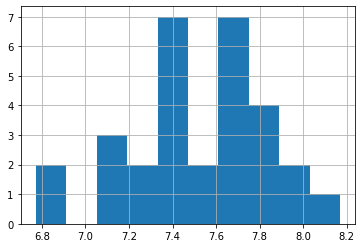

In [50]:
top20_gini['avg'].hist()

In [51]:
mannwhitneyu(top20_gini['avg'],bottom20_gini['avg'])

MannwhitneyuResult(statistic=304.0, pvalue=0.015732816288628045)

In [52]:
bottom20_gini.corr()

,population_2020,overall_performance,factor_knowledge,factor_technology,factor_future_readiness,subfact_know_talent,subfact_know_training_education,subfact_know_scientific_concentration,subfact_tech_regulatory_framework,subfact_tech_capital,...,MS17-010,vulnper1k,ncve,avg,ncve2,avg2,exposure,exposureperperson,std,std2
population_2020,1.000000,-0.039347,-0.214112,0.113037,-0.057452,-0.020804,-0.171307,-0.318330,0.149248,-0.052504,...,-0.025637,-0.169158,0.277650,-0.003504,0.277650,-0.192628,0.285814,-0.168522,-0.026714,0.315903
overall_performance,-0.039347,1.000000,0.933740,0.941859,0.982231,0.925339,0.541289,0.770167,0.882509,0.808672,...,0.515687,0.041436,0.410730,-0.291871,0.410730,-0.139498,0.406474,0.040891,-0.040673,-0.369424
factor_knowledge,-0.214112,0.933740,1.000000,0.839897,0.905094,0.879790,0.685907,0.818201,0.809514,0.756563,...,0.304866,0.084494,0.177884,-0.220065,0.177884,-0.058609,0.172735,0.084181,-0.016047,-0.334130
factor_technology,0.113037,0.941859,0.839897,1.000000,0.904824,0.864586,0.471734,0.671097,0.890386,0.846124,...,0.488392,-0.016819,0.444868,-0.237081,0.444868,-0.178914,0.443580,-0.016871,-0.113365,-0.322683
factor_future_readiness,-0.057452,0.982231,0.905094,0.904824,1.000000,0.904479,0.532922,0.721456,0.876070,0.737740,...,0.480636,0.014465,0.365452,-0.256459,0.365452,-0.091632,0.361749,0.013842,-0.044882,-0.349549
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
avg2,-0.192628,-0.139498,-0.058609,-0.178914,-0.091632,-0.160099,0.086194,-0.243689,-0.063428,-0.315482,...,-0.140262,-0.099239,-0.304667,0.780517,-0.304667,1.000000,-0.303049,-0.096215,0.277542,0.489808
exposure,0.285814,0.406474,0.172735,0.443580,0.361749,0.284879,-0.061620,0.279826,0.328325,0.359892,...,0.391133,0.069736,0.999811,-0.325209,0.999811,-0.303049,1.000000,0.068025,-0.106514,-0.222005
exposureperperson,-0.168522,0.040891,0.084181,-0.016871,0.013842,0.117547,-0.117987,0.378725,-0.118218,0.157298,...,0.900118,0.999923,0.068038,-0.294501,0.068038,-0.096215,0.068025,1.000000,-0.040467,-0.335367
std,-0.026714,-0.040673,-0.016047,-0.113365,-0.044882,0.086534,-0.168794,0.078915,-0.218729,-0.033997,...,-0.044824,-0.039064,-0.100216,-0.110142,-0.100216,0.277542,-0.106514,-0.040467,1.000000,0.424440


In [53]:
top20_gini

,country_code,country,population_2020,population_source,factor_sources,overall_performance,factor_knowledge,factor_technology,factor_future_readiness,subfact_know_talent,...,vulnper1k,ncve,avg,ncve2,avg2,exposure,exposureperperson,std,std2,income_group
200,ZA,South Africa,59309000.0,United Nations,IMD World Digital Competitiveness,60.0,60.0,55.0,57.0,59.0,...,10.787907,639820.0,7.290604,639820.0,5.304822,4664674.0,0.078650,1.613189,1.435427,Upper middle
147,NaN,Namibia,2541000.0,United Nations,NaN,NaN,NaN,NaN,NaN,NaN,...,1.920504,4880.0,7.793627,4880.0,5.737582,38032.9,0.014968,1.696592,1.374872,NaN
208,SR,Suriname,587000.0,United Nations,NaN,NaN,NaN,NaN,NaN,NaN,...,2.272572,1334.0,7.737031,1334.0,5.616042,10321.2,0.017583,1.604050,1.432357,Upper middle
245,ZM,Zambia,18384000.0,United Nations,NaN,NaN,NaN,NaN,NaN,NaN,...,0.549500,10108.0,7.357657,10108.0,5.504788,74371.2,0.004045,1.679430,1.303273,Lower middle
42,CF,Central African Republic,4830000.0,United Nations,NaN,NaN,NaN,NaN,NaN,NaN,...,0.786957,3802.0,7.372804,3802.0,5.668858,28031.4,0.005804,1.779735,1.311130,Low
121,LS,Lesotho,2142000.0,United Nations,NaN,NaN,NaN,NaN,NaN,NaN,...,3.334267,7145.0,7.635759,7145.0,5.693940,54557.5,0.025470,1.619167,1.396158,Lower middle
145,MZ,Mozambique,31255000.0,United Nations,NaN,NaN,NaN,NaN,NaN,NaN,...,0.612798,19165.0,7.272481,19165.0,5.563574,139377.1,0.004459,1.674826,1.262091,Low
29,BR,Brazil,212559000.0,United Nations,IMD World Digital Competitiveness,51.0,57.0,57.0,43.0,62.0,...,21.203925,4508313.0,7.610729,4508313.0,5.588912,34311548.2,0.161421,1.596031,1.340168,Upper middle
27,BW,Botswana,2352000.0,United Nations,NaN,NaN,NaN,NaN,NaN,NaN,...,14.417517,33918.0,7.440554,33918.0,5.574067,252368.7,0.107300,1.617229,1.352039,Upper middle
21,BZ,Belize,398000.0,United Nations,NaN,NaN,NaN,NaN,NaN,NaN,...,405.319095,161320.0,7.986741,161320.0,5.744551,1288421.0,3.237239,1.305961,1.181229,Upper middle


In [54]:
country_bscore[country_bscore.gini_value>0].shape

(157, 349)

In [55]:
country_bscore[country_bscore.gini_value>0].shape

(157, 349)

In [56]:
set(top20_gini.country) & set(top_gdp)

set()

In [57]:
country_bscore[country_bscore.country.isin(list(top_gdp))][['country', 'population_2020',
        'overall_performance', 'factor_knowledge',
       'factor_technology', 'factor_future_readiness', 'subfact_know_talent',
       'subfact_know_training_education',
       'subfact_know_scientific_concentration',
       'subfact_tech_regulatory_framework', 'subfact_tech_capital',
       'subfact_tech_technological_framework', 'subfact_fr_adaptive_attitudes',
       'subfact_fr_business_agility', 'subfact_fr_it_integration',
       'gini_value', 'totalcount','avg']].corr()['avg']

population_2020                          0.056159
overall_performance                     -0.000341
factor_knowledge                        -0.107196
factor_technology                        0.126039
factor_future_readiness                 -0.036956
subfact_know_talent                      0.043599
subfact_know_training_education         -0.061700
subfact_know_scientific_concentration   -0.285222
subfact_tech_regulatory_framework        0.138468
subfact_tech_capital                     0.055971
subfact_tech_technological_framework     0.086206
subfact_fr_adaptive_attitudes            0.227723
subfact_fr_business_agility              0.156841
subfact_fr_it_integration                0.135002
gini_value                              -0.192899
totalcount                              -0.121782
avg                                      1.000000
Name: avg, dtype: float64

In [58]:
corrlist=['country', 'population_2020',
        'overall_performance', 'factor_knowledge',
       'factor_technology', 'factor_future_readiness', 'subfact_know_talent',
       'subfact_know_training_education',
       'subfact_know_scientific_concentration',
       'subfact_tech_regulatory_framework', 'subfact_tech_capital',
       'subfact_tech_technological_framework', 'subfact_fr_adaptive_attitudes',
       'subfact_fr_business_agility', 'subfact_fr_it_integration',
       'gini_value', 'totalcount','vulnper1k','avg']

country_bscore['lavg']=np.log(country_bscore['avg'])
country_bscore['lvulnper1k']=np.log(country_bscore['vulnper1k'])
country_bscore['lsubfact_know_scientific_concentration']=np.log(country_bscore['subfact_know_scientific_concentration'])

country_bscore[country_bscore.country.isin(list(bottom20_gini.country))][['country', 'population_2020',
        'overall_performance', 'factor_knowledge',
       'factor_technology', 'factor_future_readiness', 'subfact_know_talent',
       'subfact_know_training_education',
       'subfact_know_scientific_concentration',
       'subfact_tech_regulatory_framework', 'subfact_tech_capital',
       'subfact_tech_technological_framework', 'subfact_fr_adaptive_attitudes',
       'subfact_fr_business_agility', 'subfact_fr_it_integration',
       'gini_value', 'totalcount','avg']].corr()['avg']

population_2020                         -0.003504
overall_performance                     -0.291871
factor_knowledge                        -0.220065
factor_technology                       -0.237081
factor_future_readiness                 -0.256459
subfact_know_talent                     -0.340204
subfact_know_training_education          0.097745
subfact_know_scientific_concentration   -0.510497
subfact_tech_regulatory_framework       -0.055621
subfact_tech_capital                    -0.399227
subfact_tech_technological_framework    -0.257625
subfact_fr_adaptive_attitudes           -0.134696
subfact_fr_business_agility             -0.040808
subfact_fr_it_integration               -0.175582
gini_value                               0.011767
totalcount                              -0.330227
avg                                      1.000000
Name: avg, dtype: float64

<AxesSubplot:xlabel='vulnper1k', ylabel='lsubfact_know_scientific_concentration'>

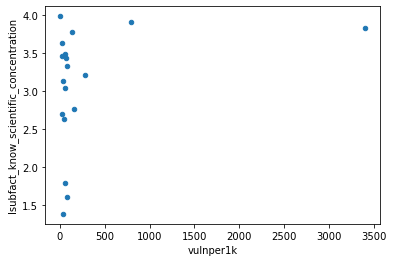

In [59]:
country_bscore[country_bscore.country.isin(list(bottom20_gini.country))].plot.scatter(x='vulnper1k',y='lsubfact_know_scientific_concentration')

<AxesSubplot:xlabel='vulnper1k', ylabel='subfact_fr_adaptive_attitudes'>

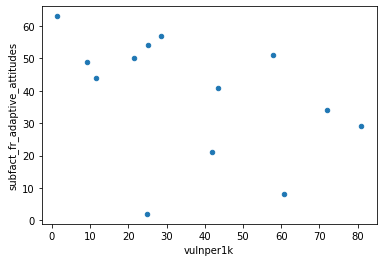

In [60]:
country_bscore[(country_bscore.vulnper1k<100) & (country_bscore.country.isin(top_vuln_countries.country))][corrlist].plot.scatter(x='vulnper1k',y='subfact_fr_adaptive_attitudes')

In [61]:
country_bscore[country_bscore.country.isin(top_vuln_countries.country)][corrlist].corr()

,population_2020,overall_performance,factor_knowledge,factor_technology,factor_future_readiness,subfact_know_talent,subfact_know_training_education,subfact_know_scientific_concentration,subfact_tech_regulatory_framework,subfact_tech_capital,subfact_tech_technological_framework,subfact_fr_adaptive_attitudes,subfact_fr_business_agility,subfact_fr_it_integration,gini_value,totalcount,vulnper1k,avg
population_2020,1.000000,0.480874,0.380167,0.558142,0.396258,0.473970,0.277472,0.323049,0.484214,0.429686,0.565903,0.092379,0.121043,0.278097,0.184490,0.039973,-0.156779,-0.084255
overall_performance,0.480874,1.000000,0.974942,0.972916,0.980123,0.960278,0.858916,0.872527,0.952686,0.922996,0.868649,0.645431,0.749254,0.664860,0.676533,-0.060526,-0.280368,0.344848
factor_knowledge,0.380167,0.974942,1.000000,0.913017,0.965124,0.959977,0.921340,0.859134,0.923493,0.858062,0.825275,0.704513,0.826573,0.753690,0.617124,-0.110042,-0.345124,0.337780
factor_technology,0.558142,0.972916,0.913017,1.000000,0.946716,0.923855,0.807039,0.786747,0.966742,0.928263,0.899658,0.492898,0.641813,0.518858,0.657930,0.020079,-0.262889,0.341894
factor_future_readiness,0.396258,0.980123,0.965124,0.946716,1.000000,0.930924,0.856023,0.835994,0.955754,0.897255,0.808955,0.627907,0.763714,0.629421,0.633988,-0.011871,-0.194450,0.377213
subfact_know_talent,0.473970,0.960278,0.959977,0.923855,0.930924,1.000000,0.847683,0.782218,0.901038,0.854039,0.888035,0.620675,0.764856,0.675776,0.671057,-0.102665,-0.402320,0.306631
subfact_know_training_education,0.277472,0.858916,0.921340,0.807039,0.856023,0.847683,1.000000,0.697891,0.861789,0.704960,0.749674,0.546890,0.817327,0.670728,0.408486,-0.042007,-0.369155,0.081285
subfact_know_scientific_concentration,0.323049,0.872527,0.859134,0.786747,0.835994,0.782218,0.697891,1.000000,0.759668,0.871261,0.605469,0.778278,0.676860,0.739744,0.692931,-0.176271,-0.131798,0.383912
subfact_tech_regulatory_framework,0.484214,0.952686,0.923493,0.966742,0.955754,0.901038,0.861789,0.759668,1.000000,0.858719,0.819321,0.495227,0.687702,0.548774,0.539164,0.119422,-0.189348,0.298329
subfact_tech_capital,0.429686,0.922996,0.858062,0.928263,0.897255,0.854039,0.704960,0.871261,0.858719,1.000000,0.782870,0.532393,0.612292,0.492854,0.756553,-0.104968,-0.215059,0.470300


In [62]:
top_vuln_per1k=country_bscore[country_bscore.overall_performance>0].sort_values(by='vulnper1k',ascending=False).head(50)
bottom_vuln_per1k=country_bscore[country_bscore.overall_performance>0].sort_values(by='vulnper1k',ascending=True).head(50)


In [63]:
top_vuln_per1k[corrlist].corr()

,population_2020,overall_performance,factor_knowledge,factor_technology,factor_future_readiness,subfact_know_talent,subfact_know_training_education,subfact_know_scientific_concentration,subfact_tech_regulatory_framework,subfact_tech_capital,subfact_tech_technological_framework,subfact_fr_adaptive_attitudes,subfact_fr_business_agility,subfact_fr_it_integration,gini_value,totalcount,vulnper1k,avg
population_2020,1.000000,0.003658,-0.036163,0.067087,-0.021101,0.141311,0.135263,-0.289935,0.157293,-0.005685,0.030684,-0.123004,-0.042386,0.002162,0.419161,0.608194,-0.112682,-0.120360
overall_performance,0.003658,1.000000,0.924099,0.932942,0.955374,0.906571,0.671065,0.720206,0.859431,0.830344,0.817676,0.784815,0.779020,0.810369,0.372582,-0.000926,-0.037885,0.039869
factor_knowledge,-0.036163,0.924099,1.000000,0.811534,0.831550,0.827036,0.827423,0.806110,0.734221,0.741832,0.729469,0.723206,0.674040,0.757792,0.423397,-0.136464,-0.032934,0.031513
factor_technology,0.067087,0.932942,0.811534,1.000000,0.859462,0.880187,0.570964,0.560102,0.902065,0.891674,0.869165,0.633011,0.679899,0.702362,0.366281,0.044904,-0.061794,0.100724
factor_future_readiness,-0.021101,0.955374,0.831550,0.859462,1.000000,0.843058,0.570321,0.653901,0.810133,0.750631,0.731259,0.811551,0.831179,0.789434,0.273475,0.027499,-0.027844,0.006329
subfact_know_talent,0.141311,0.906571,0.827036,0.880187,0.843058,1.000000,0.531024,0.562041,0.876103,0.781662,0.721409,0.682321,0.727831,0.743410,0.387559,0.034288,0.009052,0.037873
subfact_know_training_education,0.135263,0.671065,0.827423,0.570964,0.570321,0.531024,1.000000,0.510563,0.504867,0.506136,0.535986,0.469174,0.462477,0.504178,0.441701,-0.094149,-0.177669,0.038533
subfact_know_scientific_concentration,-0.289935,0.720206,0.806110,0.560102,0.653901,0.562041,0.510563,1.000000,0.459276,0.556373,0.512417,0.642553,0.490983,0.624015,0.240663,-0.118345,0.188623,-0.071984
subfact_tech_regulatory_framework,0.157293,0.859431,0.734221,0.902065,0.810133,0.876103,0.504867,0.459276,1.000000,0.755249,0.673645,0.585985,0.633491,0.704101,0.321156,0.089281,-0.132227,0.155784
subfact_tech_capital,-0.005685,0.830344,0.741832,0.891674,0.750631,0.781662,0.506136,0.556373,0.755249,1.000000,0.674218,0.554317,0.601224,0.651310,0.222836,-0.025685,0.040017,0.133181


<AxesSubplot:xlabel='vulnper1k', ylabel='factor_knowledge'>

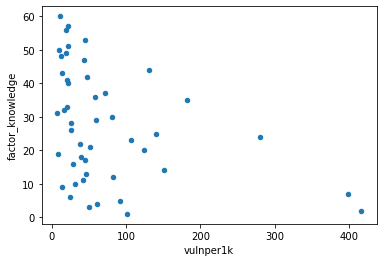

In [64]:
top_vuln_per1k[top_vuln_per1k.vulnper1k<450].plot.scatter(x='vulnper1k',y='factor_knowledge')

In [65]:
mannwhitneyu(top_vuln_per1k['factor_knowledge'],bottom_vuln_per1k['factor_knowledge'])

MannwhitneyuResult(statistic=1023.5, pvalue=0.05959573355316498)

In [66]:
mannwhitneyu(top_vuln_per1k['factor_future_readiness'],bottom_vuln_per1k['factor_future_readiness'])

MannwhitneyuResult(statistic=1079.5, pvalue=0.12057833359563125)

In [67]:

df_p=pd.DataFrame(columns=corrlist[1:], index=corrlist[1:])

In [68]:
for i in corrlist[1:]:
    print(i,mannwhitneyu(top_vuln_per1k[i],bottom_vuln_per1k[i])[1])

population_2020 0.06641699567531233
overall_performance 0.07191828722367843
factor_knowledge 0.05959573355316498
factor_technology 0.0540888126187296
factor_future_readiness 0.12057833359563125
subfact_know_talent 0.12908816696865705
subfact_know_training_education 0.07927642836737064
subfact_know_scientific_concentration 0.16378230369000407
subfact_tech_regulatory_framework 0.062934396186547
subfact_tech_capital 0.25623851177853496
subfact_tech_technological_framework 0.031577669190500285
subfact_fr_adaptive_attitudes 0.2179597669687856
subfact_fr_business_agility 0.2977465937142818
subfact_fr_it_integration 0.07097071780859074
gini_value 0.13572145514349943
totalcount 0.0318235799742811
vulnper1k 4.9010173043620706e-05
avg 0.46155212975882925


In [69]:
df_p

,population_2020,overall_performance,factor_knowledge,factor_technology,factor_future_readiness,subfact_know_talent,subfact_know_training_education,subfact_know_scientific_concentration,subfact_tech_regulatory_framework,subfact_tech_capital,subfact_tech_technological_framework,subfact_fr_adaptive_attitudes,subfact_fr_business_agility,subfact_fr_it_integration,gini_value,totalcount,vulnper1k,avg
population_2020,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
overall_performance,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
factor_knowledge,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
factor_technology,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
factor_future_readiness,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
subfact_know_talent,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
subfact_know_training_education,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
subfact_know_scientific_concentration,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
subfact_tech_regulatory_framework,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
subfact_tech_capital,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [70]:
pc=sp.posthoc_conover(country_bscore[~country_bscore.income_group.isna()], val_col='gini_value', group_col='income_group')
pc

/home/jarvis4444/anaconda3/envs/enisa/lib/python3.9/site-packages/scikit_posthocs/_posthocs.py:215: RuntimeWarning:

invalid value encountered in sqrt



,High,Low,Lower middle,Upper middle
High,1.0,NaN,NaN,NaN
Low,NaN,1.0,NaN,NaN
Lower middle,NaN,NaN,1.0,NaN
Upper middle,NaN,NaN,NaN,1.0


(<AxesSubplot:>, <matplotlib.colorbar.ColorbarBase at 0x7f3fd6eb5160>)

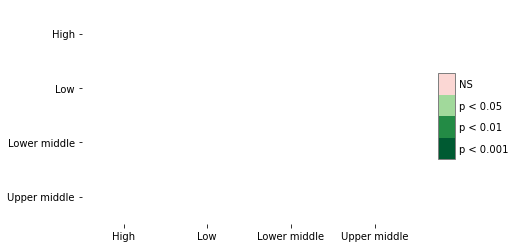

In [72]:
heatmap_args = {'linewidths': 0.25, 'linecolor': '1.5',  'square': True, 'cbar_ax_bbox': [0.90, 0.35, 0.04, 0.3]}
sp.sign_plot(pc)

In [101]:
df_GCI = util.tidy_split(df,column='GCI',sep=',')
df_GCI=df_GCI[df_GCI['GCI']!='nan']
df_GCI.head(5)

,country_code,country,GDP,GCI,globalrank,population_2020,population_source,factor_sources,overall_performance,factor_knowledge,...,CVE-2019-9712,CVE-2019-9713,CVE-2019-9714,CVE-2019-9787,CVE-2020-0796,CVE-2020-11651,CVE-2020-11652,CVE-2020-1938,CVE-2020-5902,MS17-010
0,AF,Afghanistan,1803.987,0.265,20.0,38928000.0,United Nations,NaN,NaN,NaN,...,0.0,0.0,0.0,1.0,4.0,0.0,0.0,0.0,0.0,0.0
2,AL,Albania,11803.43,0.206,22.0,2878000.0,United Nations,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,21.0,0.0,0.0,7.0,0.0,3.0
3,DZ,Algeria,13913.84,0.176,23.0,43851000.0,United Nations,NaN,NaN,NaN,...,0.0,0.0,0.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0
5,AD,Andorra,NaN,0.059,27.0,77000.0,United Nations,NaN,NaN,NaN,...,0.0,0.0,0.0,9.0,85.0,0.0,0.0,5.0,0.0,3.0
6,AO,Angola,5819.495,0.088,26.0,32866000.0,United Nations,NaN,NaN,NaN,...,0.0,0.0,0.0,8.0,100.0,0.0,0.0,8.0,0.0,18.0


In [102]:
df_SP = df_GCI[["country","GCI", "gini_value"]]

In [103]:
df_SP

,country,GCI,gini_value
0,Afghanistan,0.265,0.0
2,Albania,0.206,33.2
3,Algeria,0.176,27.6
5,Andorra,0.059,0.0
6,Angola,0.088,51.3
...,...,...,...
240,Venezuela,0.206,46.9
241,Vietnam,0.324,35.3
244,Yemen,0.059,36.7
245,Zambia,0.147,57.1


Text(0, 0.5, 'Gini Value')

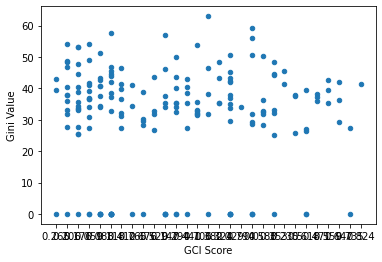

In [104]:
df_GCI.plot.scatter(x='GCI',y='gini_value')
plt.xlabel("GCI Score")
plt.ylabel("Gini Value")

In [105]:
df_GDP = util.tidy_split(df,column='GDP',sep=',')
df_GDP=df_GDP[df_GDP['GDP']!='nan']
df_GDP.head(5)

,country_code,country,GDP,GCI,globalrank,population_2020,population_source,factor_sources,overall_performance,factor_knowledge,...,CVE-2019-9712,CVE-2019-9713,CVE-2019-9714,CVE-2019-9787,CVE-2020-0796,CVE-2020-11651,CVE-2020-11652,CVE-2020-1938,CVE-2020-5902,MS17-010
0,AF,Afghanistan,1803.987,0.265,20.0,38928000.0,United Nations,NaN,NaN,NaN,...,0.0,0.0,0.0,1.0,4.0,0.0,0.0,0.0,0.0,0.0
2,AL,Albania,11803.43,0.206,22.0,2878000.0,United Nations,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,21.0,0.0,0.0,7.0,0.0,3.0
3,DZ,Algeria,13913.84,0.176,23.0,43851000.0,United Nations,NaN,NaN,NaN,...,0.0,0.0,0.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0
6,AO,Angola,5819.495,0.088,26.0,32866000.0,United Nations,NaN,NaN,NaN,...,0.0,0.0,0.0,8.0,100.0,0.0,0.0,8.0,0.0,18.0
8,AG,Antigua and Barbuda,21490.94,0.118,25.0,98000.0,United Nations,NaN,NaN,NaN,...,2.0,1.0,2.0,212.0,610.0,0.0,0.0,56.0,4.0,41.0


In [109]:
df_GDP1 = df_GDP[["country","GCI", "GDP"]]
df_GDP1

,country,GCI,GDP
0,Afghanistan,0.265,1803.987
2,Albania,0.206,11803.43
3,Algeria,0.176,13913.84
6,Angola,0.088,5819.495
8,Antigua and Barbuda,0.118,21490.94
...,...,...,...
238,Uzbekistan,0.147,6253.104
239,Vanuatu,0.147,2921.909
241,Vietnam,0.324,6171.884
245,Zambia,0.147,3689.251


In [114]:
df_GDP2 = df_GDP1.nlargest(20,'GCI')

Text(0, 0.5, 'GDP')

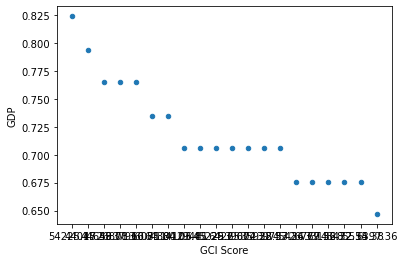

In [117]:
df_GDP2.plot.scatter(x='GDP',y='GCI')
plt.xlabel("GCI Score")
plt.ylabel("GDP")